In [1]:
# Install library for reading JPK File
%pip uninstall pyafmreader --yes
%pip install git+https://github.com/jlopezalo/pyafmreader.git

Found existing installation: pyafmreader x.x.x
Uninstalling pyafmreader-x.x.x:
  Successfully uninstalled pyafmreader-x.x.x
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmreader.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-kc0vq136
  Running command git clone -q https://github.com/jlopezalo/pyafmreader.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-kc0vq136
  Cloning https://github.com/TkTech/fasterzip.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-eas6jcn4/fasterzip_2e2f286808114c1d9e97feb06fc02b97
  Running command git clone -q https://github.com/TkTech/fasterzip.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-eas6jcn4/fasterzip_2e2f286808114c1d9e97feb06fc02b97
  Using cached numpy-1.21.6-cp38-cp38-macosx_10_9_x86_64.whl (16.9 MB)
  Created wheel for pyafmreader: filename=pyafmreader-x.x.x-py3-none-any.whl si

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-vw2othbg
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-vw2othbg
  Using cached numpy-1.23.0-cp38-cp38-macosx_10_9_x86_64.whl (18.1 MB)
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=26417 sha256=371625467f9a59b62e9bd2795c0a2951683c8ecf579f528934c42feb8cedb47b
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-khq5t0xs/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling

In [1]:
# Import libraries we will need
import numpy as np
import matplotlib.pyplot as plt

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.models.hertz import HertzModel
from pyafmrheo.models.ting import TingModel

In [2]:
# Define global variables
# file_path = '/Users/javierlopez/Documents/Marseille/05-11-2021/E/map-data-2021.11.05-15.41.45.699.jpk-force-map'
file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200903_Egel2.0_00023.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200904_Egel4-Z1.0_00025.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/08171528.0_00001.pfc'
# Shapes available: paraboloid, pyramid
indenter_shape = "pyramid"
# tip_parameter = 500 * 1e-9 # meters
tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [3]:
file = loadfile(file_path)

In [4]:
filemetadata = file.filemetadata
print(filemetadata)

{'file_path': '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200903_Egel2.0_00023.spm', 'Entry_filename': '20200903_Egel2.0_00023.spm', 'file_size_bytes': 2182209, 'file_type': '.spm', 'UFF_code': '_1_2_3_4_5', 'Entry_UFF_version': '0', 'version': '0x0920B046', 'instru': 'MultiMode 8', 'scanner': '10776jvlr_20200108_5V.scn', 'zscan_sens_nmbyV': 13.203, 'force_volume': 1, 'xoffset_nm': 0.0, 'yoffset_nm': 0.0, 'piezo_nb_sampsline': 16, 'xy_closed_loop': 'Off', 'z_closed_loop': 'Off', 'PFC_nb_samppoints': 128, 'NEW_sync_dist': 0, 'QNM_sync_dist': 0, 'PFC_amp': 100.0, 'ramp_size_V': 151.4807, 'PFC_freq': 2.0, 'peakforce': 0, 'defl_sens_nmbyV': 27.39, 'sens_z_sensor': 906.473, 'scan_rate_Hz': 1.01725, 'speed_forward_Vbys': 308.188, 'speed_reverse_Vbys': 308.188, 'nb_point_approach': 1024, 'nb_point_retract': 1024, 'trigger_mode': 'Relative', 'FDC_nb_sampsline': 16, 'defl_sens_corr': 1.08, 'defl_sens_Vbybyte': 0.000375, 'data_offset': 80960, 'FDC_data_length': 2097152, 'byte_per

In [7]:
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant
    
print(file_spring_constant)
print(deflection_sensitivity)

height
0.1332
2.739e-08


In [120]:
curve_idx = 0
force_curve = file.getcurve(curve_idx)
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = force_curve.get_segments()

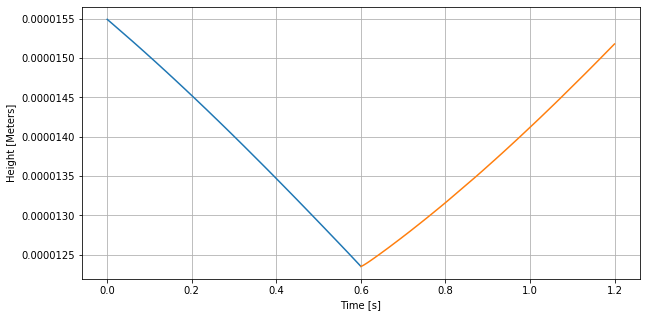

In [121]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    if seg_id == '1':
         height = height[::-1]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

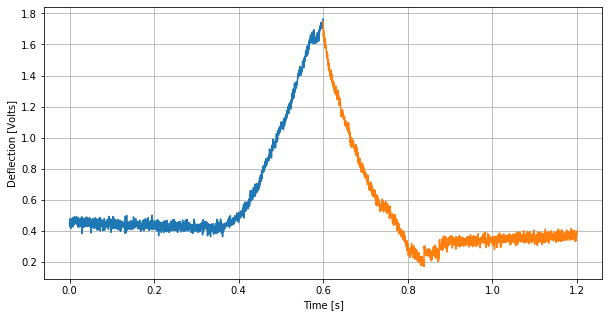

In [122]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

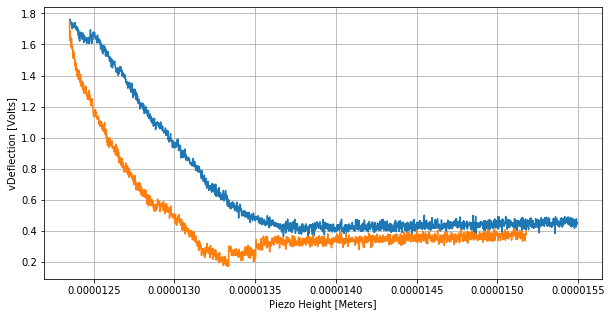

In [123]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [124]:
force_curve.preprocess_force_curve(deflection_sensitivity, height_channel)

# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]

In [130]:
# Shift height
force_curve.shift_height()

In [131]:
app_height = first_ext_seg.zheight
app_deflection = first_ext_seg.vdeflection
ret_height = last_ret_seg.zheight
ret_deflection = last_ret_seg.vdeflection

In [132]:
# Find initial PoC, you may get some warnings.
poc = get_poc_RoV_method(app_height, app_deflection, win_size=50)
print(*poc)

1.5863563987854109e-06 1.375145042506078e-09


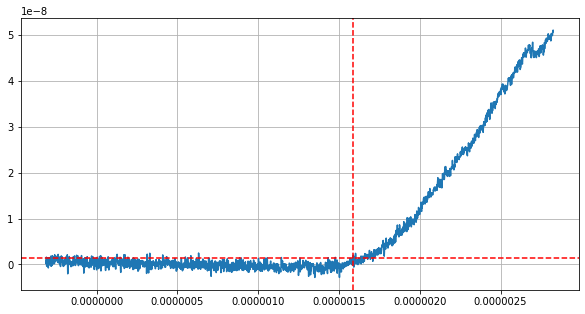

In [133]:
plt.plot(app_height, app_deflection)
plt.axvline(x=poc[0], color='r', linestyle='--')
plt.axhline(y=poc[1], color='r', linestyle='--')
plt.grid()
plt.show()


        # Fit parameters
        Indenter shape: pyramid

        Tip paraneter: 35

        BEC Model: None

        Number of free parameters: 3

        delta0: -1.7727182488542376e-07

        E0: 454.1597820735862

        f0: -1.0557846617158682e-11

        slope: None

        # Fit metrics
        MAE: 8.453446798958857e-20

        MSE: 2.682450987579076e-22

        RMSE: 1.637818972774182e-11

        Rsq: 0.9869430250468212

        Chisq: -1.0477459082043078e-08

        RedChisq: -3.4924863606810258e-09

        
454.1597820735862


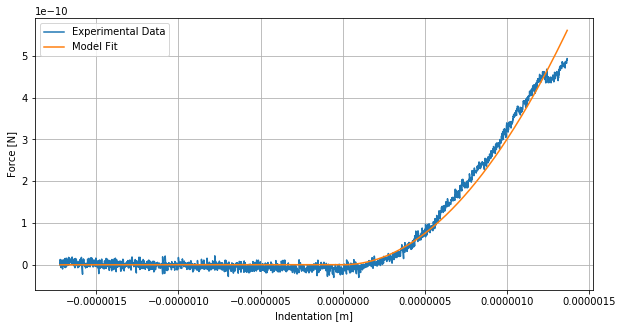

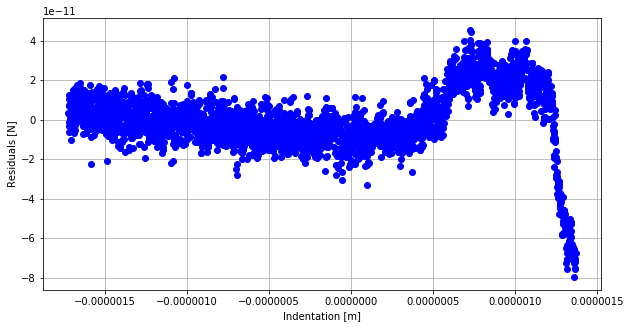

In [134]:
# Hertz fit
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force = first_ext_seg.indentation, first_ext_seg.force

# plt.plot(app_height - poc[0], app_deflection*spring_constant)
# plt.show()

# app_indentation = app_height - poc[0]
# app_force = app_deflection*spring_constant

hertzmodel = HertzModel(indenter_shape, tip_parameter)
hertzmodel.fit(app_indentation, app_force)

hertzmodel.fit_report()

hertz_E0 = hertzmodel.E0
hertz_d0 = hertzmodel.delta0
hertz_f0 = hertzmodel.f0

print(hertz_E0)

# Plot Hertz Fit results
plt.plot(app_indentation-hertz_d0, app_force-hertz_f0, label="Experimental Data")
plt.plot(app_indentation-hertz_d0, hertzmodel.eval(app_indentation)-hertz_f0, label="Model Fit")
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.legend()
plt.grid()
plt.show()

# Plot residuals
plt.plot(app_indentation-hertz_d0, hertzmodel.get_residuals(app_indentation, app_force), "bo")
plt.xlabel('Indentation [m]')
plt.ylabel('Residuals [N]')
plt.grid()
plt.show()

In [135]:
# Get force vs indentation for all segments
poc[0] += hertz_d0

# Get indentation and force
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force, app_time = first_ext_seg.indentation, first_ext_seg.force, first_ext_seg.time
last_ret_seg.get_force_vs_indentation(poc, spring_constant)
ret_indentation, ret_force, ret_time = last_ret_seg.indentation, last_ret_seg.force, last_ret_seg.time

In [136]:
indentation = np.r_[app_indentation, ret_indentation]
force = np.r_[app_force, ret_force]
t0 = app_time[-1]
time = np.r_[app_time, ret_time + t0]
fit_mask = indentation > (-1 * 1e-6)
ind_fit = indentation[fit_mask]
force_fit = force[fit_mask]
force_fit = force_fit - force_fit[0]
time_fit = time[fit_mask]
time_fit = time_fit - time_fit[0]
tm = time_fit[np.argmax(force_fit)]
tc = tm/3
idx_tm = np.argmax(force_fit)

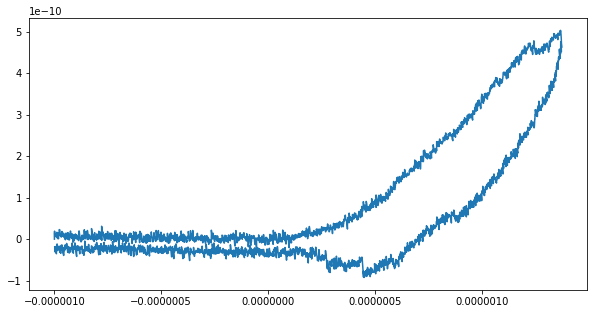

In [137]:
plt.plot(ind_fit, force_fit)
plt.show()

In [138]:
help(TingModel)

Help on class TingModel in module pyafmrheo.models.ting:

class TingModel(builtins.object)
 |  TingModel(ind_geom, tip_param, modelFt) -> None
 |  
 |  Methods defined here:
 |  
 |  SolveAnalytical(self, ttc, trc, t1, model_probe, geom_coeff, v0t, v0r, v0, E0, betaE, t0, F0, vdrag)
 |  
 |  SolveNumerical(self, delta, time_, geom_coeff, geom_exp, v0t, v0r, E0, betaE, F0, vdrag, smooth_w, idx_tm, idxCt, idxCr)
 |  
 |  __init__(self, ind_geom, tip_param, modelFt) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  eval(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  fit(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  fit_report(self)
 |  
 |  get_chisq(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  get_red_chisq(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  get_residuals(self, time, F, delta, t0, idx_tm=None, smooth_w=None)
 |  
 |  objective(self, time, E0, tc, betaE, F0, t0, F, delta, m

In [139]:
ting_model_num = TingModel(indenter_shape, tip_parameter, 'numerical')
ting_model_num.betaE_init = 0.9
ting_model_num.E0_init = hertz_E0
ting_model_num.tc_init = tc
ting_model_num.fit(time_fit, force_fit, ind_fit, t0=1, idx_tm=idx_tm, smooth_w=5)
ting_model_num.fit_report()
tc_num = ting_model_num.tc
f0_num = ting_model_num.F0


        # Fit parameters
        Indenter shape: pyramid

        Tip paraneter: 35

        Model Format: numerical

        Viscous Drag: 0

        Smooth Window: 5

        t0: 1

        Maximum Indentation Time: 2244

        Number of free parameters: 4

        E0: 145.3937461243597

        tc: 0.15208077839457385

        betaE: 0.27911738745029663

        F0: -2.531728091045999e-11

        # Fit metrics
        MAE: -5.7202105299133156e-21

        MSE: 4.639324960002741e-22

        RMSE: 2.1539092274287563e-11

        Rsq: 0.9785336036024492

        Chisq: -2.7214840786512712e-09

        RedChisq: -6.803710196628178e-10

        


In [140]:
ting_model_analit = TingModel(indenter_shape, tip_parameter, 'analytical')
ting_model_analit.betaE_init = 0.9
ting_model_analit.E0_init = hertz_E0
ting_model_analit.tc_init = tc
ting_model_analit.fit(time_fit, force_fit, ind_fit, t0=1, idx_tm=idx_tm, smooth_w=5)
ting_model_analit.fit_report()
tc_analit = ting_model_analit.tc
f0_analit = ting_model_analit.F0


        # Fit parameters
        Indenter shape: pyramid

        Tip paraneter: 35

        Model Format: analytical

        Viscous Drag: 0

        Smooth Window: 5

        t0: 1

        Maximum Indentation Time: 2244

        Number of free parameters: 4

        E0: 185.27598185949248

        tc: 0.1711183241039479

        betaE: 0.24860544237359714

        F0: -2.153448365668464e-11

        # Fit metrics
        MAE: 1.3744873904181968e-19

        MSE: 4.42917750285695e-22

        RMSE: 2.104561118821915e-11

        Rsq: 0.9795059667492261

        Chisq: -2.0576180532173e-09

        RedChisq: -5.14404513304325e-10

        


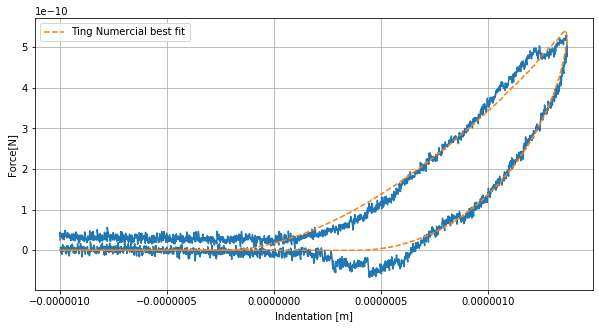

In [141]:
plt.plot(ind_fit, force_fit - f0_num)
plt.plot(ind_fit, ting_model_num.eval(time_fit, force_fit, ind_fit, t0=t0, idx_tm=idx_tm, smooth_w=5) - f0_num, '--', label='Ting Numercial best fit')
plt.xlabel("Indentation [m]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

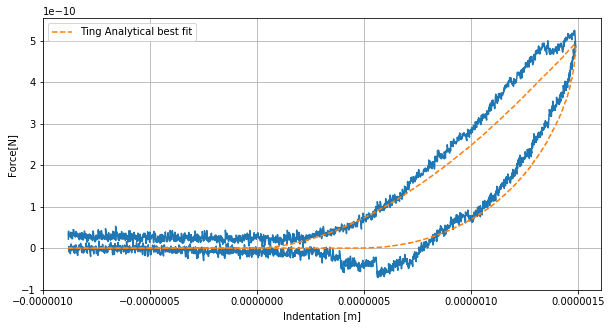

In [142]:
idx_tc = (np.abs(time_fit - tc_analit)).argmin()
delta0 = ind_fit[idx_tc]
plt.plot(ind_fit-delta0, force_fit-f0_analit)
plt.plot(ind_fit-delta0, ting_model_analit.eval(time_fit, force_fit, ind_fit, t0=t0, idx_tm=idx_tm, smooth_w=5)-f0_analit, '--', label='Ting Analytical best fit')
plt.xlabel("Indentation [m]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

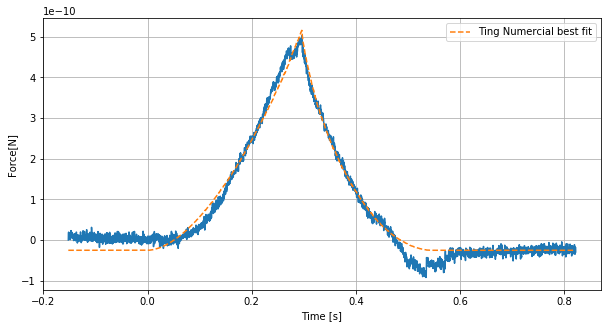

In [143]:
plt.plot(time_fit-tc_num, force_fit)
plt.plot(time_fit-tc_num, ting_model_num.eval(time_fit, force_fit, ind_fit, t0=t0, smooth_w=5), '--', label='Ting Numercial best fit')
plt.xlabel("Time [s]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

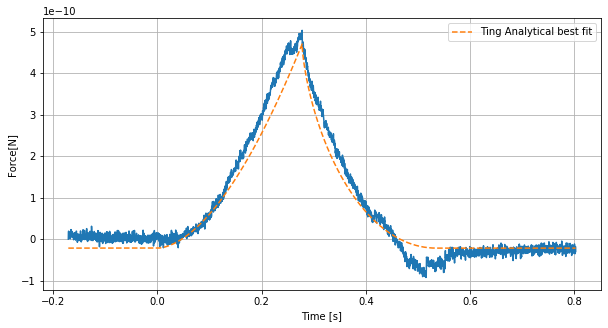

In [144]:
plt.plot(time_fit-tc_analit, force_fit)
plt.plot(time_fit-tc_analit, ting_model_analit.eval(time_fit, force_fit, ind_fit, t0=t0, smooth_w=5), '--', label='Ting Analytical best fit')
plt.xlabel("Time [s]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

In [145]:
def get_AUC(indentation, force, idx_tm):
    # App
    app_ind = indentation[:idx_tm]
    app_forc = force[:idx_tm]
    auc_app = np.trapz(app_forc, app_ind)
    
    # Ret
    ret_ind = indentation[idx_tm:]
    ret_forc = force[idx_tm:]
    auc_ret = np.trapz(ret_forc, ret_ind)
    
    auc_tot = np.trapz(force, indentation)
    
    return auc_app, auc_ret, auc_tot

In [146]:
AUCApp, AUCRet, AUCTot = get_AUC(ind_fit, force_fit, idx_tm)
print(AUCApp, AUCRet, AUCTot)

2.771054318572639e-16 -4.6270224915937226e-17 2.3116126420581405e-16


In [147]:
hertz_E0 * 1/(AUCApp-AUCRet)

1.404434046166036e+18